In [1]:
from glob import glob

from matplotlib import pyplot as plt
import seaborn as sns

import pickle
import numpy as np

In [28]:
data = {'itc': {'fac': [], 'bod': [], 'art': [], 'nat': [], 'fac0': [], 'bod0': [], 'art0': [], 'nat0': []},
        'pfc': {'fac': [], 'bod': [], 'art': [], 'nat': [], 'fac0': [], 'bod0': [], 'art0': [], 'nat0': []}}
basedir = 'G:/Results/SUA/dec/c-ovr-final/time-time-stimulus-split'
# basedir = 'G:/Results/SUA/dec/c-ovr-final/time-time'

for fname in glob(f'{basedir}\c-ovr-r-*-dpr.pickle'):
    with open(fname, 'rb') as handler:
        dpr = pickle.load(handler)

    for region in ['itc', 'pfc']:
        for category in ['fac', 'bod', 'art', 'nat']:
            X = dpr[region][category]
            data[region][category].append(X[np.random.choice(np.shape(X)[0])])
            # data[region][category].append(dpr[region][category])
            # data[region][category].append(np.mean(dpr[region][category], 0))

for fname in glob(f'{basedir}\c-ovr-p-*-dpr.pickle'):
    with open(fname, 'rb') as handler:
        dpr = pickle.load(handler)

    for region in ['itc', 'pfc']:
        for category in ['fac', 'bod', 'art', 'nat']:
            X = dpr[region][category]
            data[region][category+"0"].append(X[np.random.choice(np.shape(X)[0])])
            # data[region][category+"0"].append(dpr[region][category][])
            # data[region][category+"0"].append(np.mean(dpr[region][category], 0))

for region in ['itc', 'pfc']:
    for key in data[region].keys():
        data[region][key] = np.array(data[region][key])

In [29]:
from mne.stats import permutation_cluster_1samp_test, ttest_1samp_no_p
from scipy import stats
from itertools import product
# import statsmodels as sm

from functools import partial
sigma=1
stat_fun_hat = partial(ttest_1samp_no_p, sigma=sigma)

p_ = []

for (region, category) in product(['itc', 'pfc'], ['fac', 'bod', 'art', 'nat']):
    Z0 = data[region][f'{category}0']
    Z  = data[region][f'{category}']
    T = (Z - Z0.mean(0)) / (Z0.std(0))
    ntime = T.shape[1]

    alpha = 0.05 / (ntime * ntime)
    n_samples = Z.shape[0]
    
    threshold = stats.distributions.t.ppf(1 - alpha, n_samples - 1)
    # threshold = dict(start=0, step=0.2)
    t_clust, clusters, p_values, H0 = permutation_cluster_1samp_test(
        T, n_jobs=8, threshold=threshold, stat_fun=stat_fun_hat, buffer_size=None,
        n_permutations=1000, verbose=0)

    ts, ps, mccs = [], [], []
    p_clust = np.ones((ntime, ntime))
    for cl, p in zip(clusters, p_values):
        p_clust[cl] = p
    ts.append(t_clust)
    ps.append(p_clust)
    mccs.append(True)
    
    p = -np.log10(np.reshape(np.maximum(ps, 1e-5), (ntime, ntime)))
    p_.append(p)

100%|██████████|  : 999/999 [00:04<00:00,  210.83it/s]
100%|██████████|  : 999/999 [00:03<00:00,  282.64it/s]
100%|██████████|  : 999/999 [00:03<00:00,  303.54it/s]
100%|██████████|  : 999/999 [00:03<00:00,  301.16it/s]
100%|██████████|  : 999/999 [00:03<00:00,  294.34it/s]
100%|██████████|  : 999/999 [00:03<00:00,  295.87it/s]
100%|██████████|  : 999/999 [00:03<00:00,  290.06it/s]
100%|██████████|  : 999/999 [00:03<00:00,  285.79it/s]


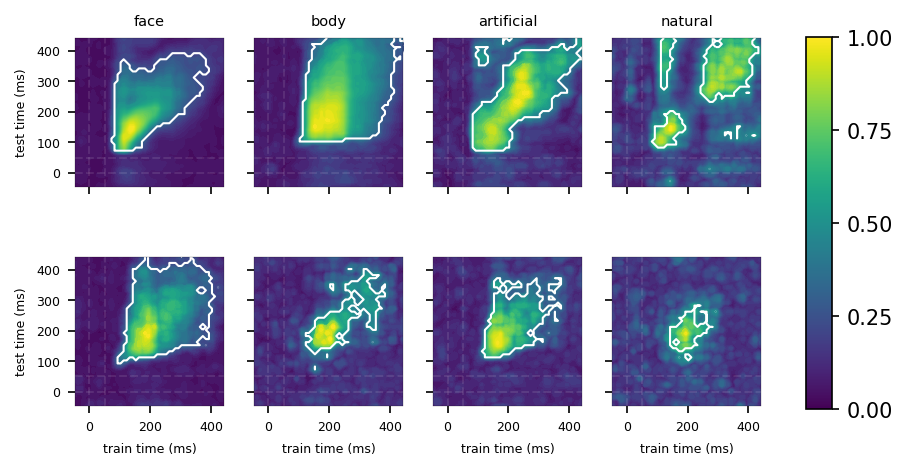

In [30]:
from mne.stats import permutation_cluster_1samp_test
from scipy import stats
from itertools import product
# import statsmodels as sm
from matplotlib.cm import ScalarMappable

cmap = 'viridis'

mm = 1 / 25.4
# tim = np.arange(-200, 675, step=5) + 12.5
tim = np.arange(-200, 675, step=10) + 12.5
tim = tim[:-1]
timind = ((tim < 450) & (tim > -50)).flatten()
fig, axs = plt.subplots(2, 4, figsize=(150 * mm, 90 * mm), dpi=150, sharey=True, sharex=True, squeeze=False)
# axs = axs.flatten()

for itr, (ax, (region, category)) in enumerate(zip(axs.flat, product(['itc', 'pfc'], ['fac', 'bod', 'art', 'nat']))):
    Z0 = data[region][f'{category}0']
    Z  = data[region][f'{category}']
    T = (Z - Z0.mean(0)) / (Z0.std(0))

    p = p_[itr][timind][:, timind]
    x = (Z.mean(0) - Z0.mean(0))[timind][:, timind]
    cnt = ax.contourf(tim[timind], tim[timind], x, levels=50, cmap=cmap)
    ax.contour(tim[timind], tim[timind], p, levels=[2.995], colors=['w'], linewidths=1)

    for c in cnt.collections:
        c.set_edgecolor("face")

for ax in axs.flat:
    for v in [0, 50]:
        ax.axvline(v, color='w', ls='--', lw=1, alpha=.1, label='_nolegend_')
        ax.axhline(v, color='w', ls='--', lw=1, alpha=.1, label='_nolegend_')
    ax.set_xlim(-50, 600)
    ax.tick_params(axis='both', which='major', labelsize=6)
    # ax.set_yticks(ax.get_xticks())
    plt.setp(ax.spines.values(), linewidth=.1)

    ax.axis('square')

for ax, category in zip(axs[0, :], ["face", "body", "artificial", "natural"]):
    ax.set_title(category, fontsize=7)

for ax in axs[1, :]:
    ax.set_xlabel('train time (ms)', fontsize=6)

for ax in axs[:, 0]:
    ax.set_ylabel('test time (ms)', fontsize=6)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.03, 0.7])
fig.colorbar(mappable=ScalarMappable(norm=c.norm, cmap=cmap),
   ticks=np.arange(0, 1+.25, step=.25), cax=cbar_ax
);

# fig.tight_layout()
# plt.savefig('timetime.pdf')

In [63]:
from tqdm.notebook import tqdm

data = {'itc': {'fac': [], 'bod': [], 'art': [], 'nat': [], 'fac0': [], 'bod0': [], 'art0': [], 'nat0': []},
        'pfc': {'fac': [], 'bod': [], 'art': [], 'nat': [], 'fac0': [], 'bod0': [], 'art0': [], 'nat0': []}}
# basedir = 'G:/Results/SUA/dec/c-ovr-final/time-time'
basedir = 'G:/Results/SUA/dec/c-ovr-final/time-time-stimulus-split/'

for fname in tqdm(glob(f'{basedir}\c-ovr-r-*-cfn.pickle')):
    with open(fname, 'rb') as handler:
        dpr = pickle.load(handler)

    for region in ['itc', 'pfc']:
        for category in ['fac', 'bod', 'art', 'nat']:
            X = np.array(dpr[region][category])
            Z = X.diagonal(axis1=3, axis2=4).sum(3) / X.sum((3, 4))
            data[region][category].append(Z[0])

for fname in tqdm(glob(f'{basedir}\c-ovr-p-*-cfn.pickle')):
    with open(fname, 'rb') as handler:
        dpr = pickle.load(handler)

    for region in ['itc', 'pfc']:
        for category in ['fac', 'bod', 'art', 'nat']:
            X = np.array(dpr[region][category])
            Z = X.diagonal(axis1=3, axis2=4).sum(3) / X.sum((3, 4))
            data[region][category+"0"].append(Z.mean(0))

for region in ['itc', 'pfc']:
    for key in data[region].keys():
        data[region][key] = np.array(data[region][key])

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

In [ ]:
from mne.stats import permutation_cluster_1samp_test, ttest_1samp_no_p
from scipy import stats
from itertools import product

from functools import partial
sigma=1
stat_fun_hat = partial(ttest_1samp_no_p, sigma=sigma)

p_ = []

for (region, category) in product(['itc', 'pfc'], ['fac', 'bod', 'art', 'nat']):
    Z0 = data[region][f'{category}0']
    Z  = data[region][f'{category}']
    T = (Z - Z0.mean(0)) / (Z0.std(0))
    ntime = T.shape[1]

    alpha = 0.05 / (ntime * ntime)
    n_samples = Z.shape[0]
    
    threshold = stats.distributions.t.ppf(1 - alpha, n_samples - 1)
    t_clust, clusters, p_values, H0 = permutation_cluster_1samp_test(
        T, n_jobs=8, threshold=threshold, stat_fun=stat_fun_hat, buffer_size=None,
        n_permutations=1000, verbose=0)

    ts, ps, mccs = [], [], []
    p_clust = np.ones((ntime, ntime))
    for cl, p in zip(clusters, p_values):
        p_clust[cl] = p
    ts.append(t_clust)
    ps.append(p_clust)
    mccs.append(True)
    
    p = -np.log10(np.reshape(np.maximum(ps, 1e-5), (ntime, ntime)))
    p_.append(p)

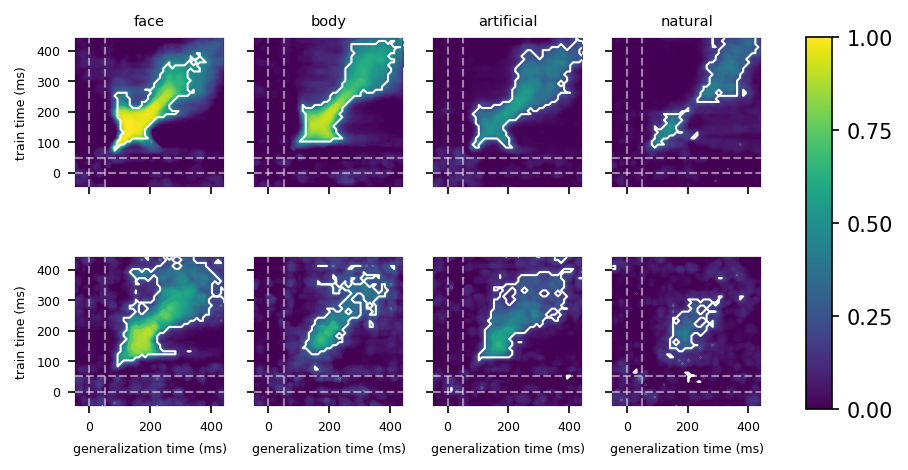

In [27]:
cmap = "viridis"

mm = 1 / 25.4

tim = np.arange(-200, 674, step=10) + 12.5
tim = tim[:-1]
timind = ((tim < 450) & (tim > -50)).flatten()

fig, axs = plt.subplots(2, 4, figsize=(150 * mm, 90 * mm), dpi=150, sharey=True, sharex=True, squeeze=False)

for itr, (ax, (region, category)) in enumerate(zip(axs.flat, product(['itc', 'pfc'], ['fac', 'bod', 'art', 'nat']))):
    X = data[region][category].mean(0)
    X = (X-.5)/(1-.5)
    X = X[timind][:, timind]

    c = ax.contourf(tim[timind], tim[timind], X, 
        levels=100, cmap=cmap, vmin=0, vmax=1)

    p = p_[itr][timind][:, timind]
    ax.contour(tim[timind], tim[timind], p, levels=[2.995], colors=['w'], linewidths=1)

    for _c in c.collections:
        _c.set_edgecolor("face")

for ax in axs.flat:
    for v in [0, 50]:
        ax.axvline(v, color='w', ls='--', lw=1, alpha=.5, label='_nolegend_')
        ax.axhline(v, color='w', ls='--', lw=1, alpha=.5, label='_nolegend_')
    ax.set_xlim(-50, 450)
    ax.set_ylim(-50, 450)
    ax.axis('square')   
    ax.tick_params(axis='both', which='major', labelsize=6)
    # ax.set_yticks(ax.get_xticks())
    plt.setp(ax.spines.values(), linewidth=.1)

for ax, category in zip(axs[0, :], ["face", "body", "artificial", "natural"]):
    ax.set_title(category, fontsize=7)

for ax in axs[1, :]:
    ax.set_xlabel('generalization time (ms)', fontsize=6)

for ax in axs[:, 0]:
    ax.set_ylabel('train time (ms)', fontsize=6)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.03, 0.7])
fig.colorbar(mappable=ScalarMappable(norm=c.norm, cmap=cmap),
   ticks=np.arange(0, 1+.25, step=.25), cax=cbar_ax
);

# fig.tight_layout()
# plt.savefig("time-generalization-acc.pdf")

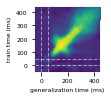

In [76]:
cmap = "viridis"
mm = 1 / 25.4

tim = np.arange(-200, 674, step=10) + 12.5
tim = tim[:-1]
timind = ((tim < 450) & (tim > -50)).flatten()

fig, axs = plt.subplots(1, 1, figsize=(40 * mm, 40 * mm))
ax = axs

region = 'itc'
X = (data[region]['fac'].mean(0) + data[region]['bod'].mean(0) + \
    data[region]['art'].mean(0) + data[region]['nat'].mean(0)) / 4
X = (X-.5)/(1-.5)
X = X[timind][:, timind]

c = ax.contourf(tim[timind], tim[timind], X, 
    levels=100, cmap=cmap)

for _c in c.collections:
    _c.set_edgecolor("face")

for v in [0, 50]:
    ax.axvline(v, color='w', ls='--', lw=1, alpha=.5, label='_nolegend_')
    ax.axhline(v, color='w', ls='--', lw=1, alpha=.5, label='_nolegend_')
ax.set_xlim(-50, 450)
ax.set_ylim(-50, 450)
ax.axis('square')   
ax.tick_params(axis='both', which='major', labelsize=6)
# ax.set_yticks(ax.get_xticks())
plt.setp(ax.spines.values(), linewidth=.1)

# ax.set_title(category, fontsize=7)
ax.set_xlabel('generalization time (ms)', fontsize=6)
ax.set_ylabel('train time (ms)', fontsize=6)

# fig.subplots_adjust(right=0.9)
# cbar_ax = fig.add_axes([0.95, 0.15, 0.03, 0.7])
# fig.colorbar(mappable=ScalarMappable(norm=c.norm, cmap=cmap),
#    ticks=np.arange(0, 1+.25, step=.25), cax=cbar_ax
# );

fig.tight_layout()
# plt.savefig("time-generalization-acc-average.png", dpi=250)
plt.savefig(r"G:\Codes\Article\IT-PFC\images\AI\time-generalization-acc-average.pdf")